In [1]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import acquire
import helpers.nlp
import helpers.viz


In [2]:
df = acquire.wrangle_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1031 non-null   object
 1   language         917 non-null    object
 2   readme_contents  1027 non-null   object
dtypes: object(3)
memory usage: 24.3+ KB


# Prepping the data

### Language Nulls
Many repositories do not have a language associated with them.  I suspect that this is due to repositories that are intended to share conceptual information rather than any actual code.

In [4]:
df[df.language.isna()].sample(10, random_state=8)

,repo,language,readme_contents
221,nodejs/node-v0.x-archive,NaN,\nThis repository is an archive of Node.js bef...
939,markerikson/react-redux-links,NaN,# React/Redux Links\nCurated tutorial and reso...
511,mbeaudru/modern-js-cheatsheet,NaN,# Modern JavaScript Cheatsheet\n\n![Modern Jav...
472,johnpapa/angular-styleguide,NaN,# Angular Style Guide\n\n## Versions\nThere ar...
186,Developer-Y/cs-video-courses,NaN,# Computer Science courses with video lectures...
2,EbookFoundation/free-programming-books,NaN,# List of Free Learning Resources In Many Lang...
733,google/eng-practices,NaN,# Google Engineering Practices Documentation\n...
610,datawhalechina/pumpkin-book,NaN,"<div align=center>\n<img src=""https://raw.gith..."
872,akullpp/awesome-java,NaN,# Awesome Java [![Awesome](https://awesome.re/...
124,enaqx/awesome-react,NaN,### **Awesome React** [![Awesome](https://cdn....


After manually inspecting some of these repos I feel confident in my assumption.  Many of these repositories are a compilation of tutorials, or a list of resources.  In fact, we should keep the following phrases/keywords in mind for identifying these types of repositories:  
- `curated [list/tutorial/resource]`
- `courses`
- `learning resource`
- `cheatsheet`

In [5]:
# Committing to the asumption and imputing as english
df.language = df.language.fillna('English')

### Readme Nulls

In [6]:
df.readme_contents.isna().sum()

4

There's only 4 of them.  I don't want to waste time investigating.  We'll just drop them.

In [7]:
df = df.dropna()

### Content cleaning
As a starting point we'll normalize the text

In [8]:
df['cleaned'] = helpers.nlp.make_clean_col(df.readme_contents)

In [9]:
def get_word_freq(document, max=None, min=None):
    if type(document) != str:
        document = ' '.join(document)
    bag =  document.split(' ')
    series = pd.Series(bag)
    vc = series.value_counts()
    if max:
        vc = vc[vc <= max]
    if min:
        vc = vc[vc >= min]
    return vc


In [10]:
get_word_freq(df.cleaned)

'                                                                                   34582
&#9;                                                                                10294
use                                                                                  6390
react                                                                                5955
data                                                                                 5789
                                                                                    ...  
httpsaudiokitprocomsynth                                                                1
hrefhttpsaudiokitprocomsynthhttpsaudiokitprocomsyntha                                   1
storehttpsappsapplecomappaudiokit                                                       1
synthesizerid1371050497                                                                 1
openhttpsnetronappurlhttpsrawgithubusercontentcomalexeyabdarknetmastercfgyolocfg        1
Length: 25

The string `&#9;` is very popular. Probably because seems to point to html codes for square brackets "[]" which is very common in markup files.. which the readme files are.  We'll add this one to the stopwords list.  

We'll go ahead and add apostrophes to the stopword list as well

Also there seems to be a large amount of urls being captured as single words.  We'll want to scrub those as well to reduce noise.

In [11]:
links = re.compile(r'(\(http.+\))|(\<a href.+\>)')
df.readme_contents = df.readme_contents.replace(links, '')

In [12]:
df['cleaned'] = helpers.nlp.make_clean_col(df.readme_contents, extra_words=['&#9;', "'"])

In [13]:
get_word_freq(df.cleaned)

use                                                                   5970
react                                                                 5283
data                                                                  5193
1                                                                     4941
using                                                                 4471
                                                                      ... 
manitoba                                                                 1
healthservicesdiseasescoronavirushtml                                    1
httpswwwcanadacaenpublic                                                 1
httpsexperiencearcgiscomexperiencea6f23959a8b14bfa989e3cda29297ded       1
exermote                                                                 1
Length: 141692, dtype: int64

Hmm.. my link regex seems to have failed in some cases.  That's okay though.  This seems workable

In [14]:
df['lemma'] = df.cleaned.apply(helpers.nlp.lemmatize)

In [15]:
df.head()

,repo,language,readme_contents,cleaned,lemma
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner]\n\n[![Pull Requ...,freecodecamp social banner pull requests welco...,freecodecamp social banner pull request welcom...
1,996icu/996.ICU,English,[996.ICU]\n=======\n**Please note that there e...,996icu please note exists official account app...,996icu please note exists official account app...
2,EbookFoundation/free-programming-books,English,# List of Free Learning Resources In Many Lang...,list free learning resources many languages di...,list free learning resource many language div ...
3,jwasham/coding-interview-university,English,# Coding Interview University\n\n> I originall...,coding interview university originally created...,coding interview university originally created...
4,kamranahmedse/developer-roadmap,TypeScript,"<p align=""center"">\n <img src=""public/brand.p...",p aligncenter img srcpublicbrandpng height128 ...,p aligncenter img srcpublicbrandpng height128 ...


In [23]:
df['stem'] = df.cleaned.apply(helpers.nlp.stem)

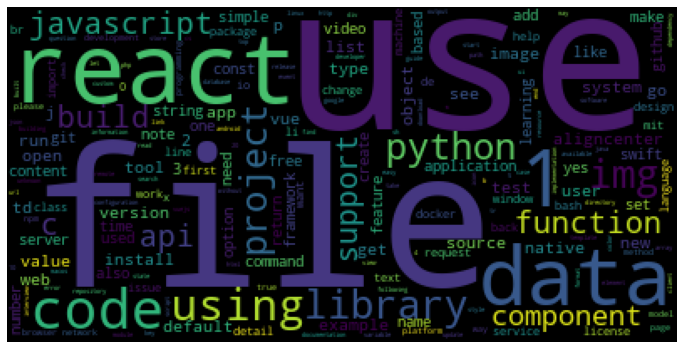

In [16]:
helpers.viz.plot_wordcloud(df.lemma)

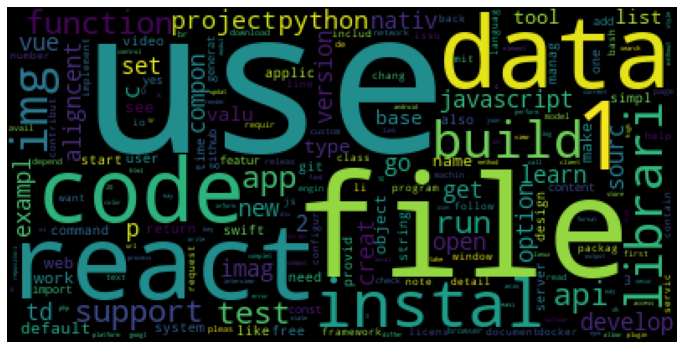

In [24]:
helpers.viz.plot_wordcloud(df.stem)